# Visualizations

## IHaskell.Display

`IHaskell` lets you define a custom display mechanism for any data type via its `IHaskell.Display` typeclass. Since you can use `IHaskell` in console mode as well as notebook mode, you can provide a list of display outputs for any data type, and the frontend will simply choose the best one. Here's how you would implement a very simple display mechanism for this Color data type:

In [1]:
import IHaskell.Display

data Color = Red | Green | Blue

instance IHaskellDisplay Color where
  display color = return $ Display [html code]
    where
      code = concat ["<div style='font-weight: bold; color:"
                    , css color
                    , "'>Look!</div>"]
      css Red   = "red"
      css Blue  = "blue"
      css Green = "green"

In [2]:
Red
Blue
Green

Look!

Look!

Look!

The `DisplayData` type has several constructors which let you display your data as plain text, HTML, images (SVG, PNG, JPG), or even as LaTeX code.

In order to ship an extension for `IHaskell`, simply create a package named `ihaskell-thing` with a module named `IHaskell.Display.Thing`. As long as `ihaskell-thing` is installed, `IHaskell` will detect and use it automatically.

## Diagrams

In [3]:
import Diagrams.Prelude
import Data.Colour.Palette.BrewerSet


### Sierpinski triangle

In [4]:
:set -XTypeFamilies

clrs :: [Colour Double]
clrs = brewerSet Purples 9

--sierpinski :: Int -> [Colour Double] -> Diagram B
sierpinski n c = go n <> triangle (2^n) # fc (head clrs) # lw none
   where
     clrs = if null c then repeat black else cycle c
     go n
       | n == 1    = t1 # fc (clrs !! 1)
       | otherwise = appends tri (zip vecs (replicate 3 sierp))
       where
         tri   = scale (2 ^ (n-1)) $ t1 # fc (clrs !! (n+1))
         vecs  = [unitY, rotateBy (-1/12) unitX, rotateBy (1/12) unit_X]
         sierp = go (n-1)
         t1    = triangle 1 # reflectY

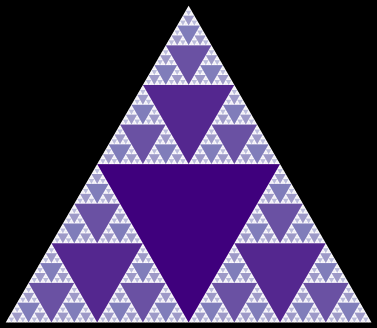

In [5]:
diagram $ sierpinski 7 clrs # lw none # center # frame 2 # bg black

### Apollonian gasket
References:
- [A Tisket, a Tasket, an Apollonian Gasket](https://www.americanscientist.org/article/a-tisket-a-tasket-an-apollonian-gasket)

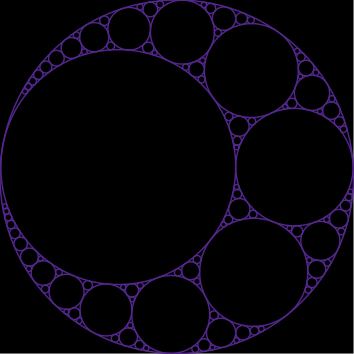

In [6]:
import Diagrams.Prelude
import Diagrams.TwoD.Apollonian
diagram $ apollonianGasket 0.01 2 4 5 # lc (clrs!!7) # bg black

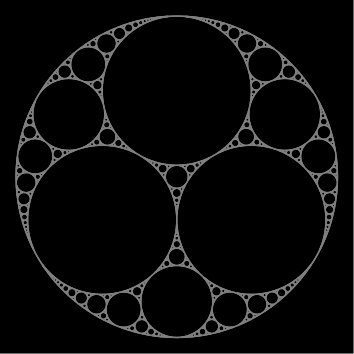

In [7]:
import Control.Lens hiding ((#))
diagram $ apollonianGasket 0.001 2 2 2 # centerXY # pad 1.1 # lc gray # bg black

#### Mandelbrot

In [8]:
import Data.Complex
import Diagrams.Prelude hiding (magnitude,image)

Code to compute orbits of complex numbers under the Mandelbrot transformation, and decide on the magnitude of a pixel based on how slowly its orbit diverges.

In [9]:
quadratic c z = z*z + c

criticalOrbit :: Complex Double -> [Complex Double]
criticalOrbit z = iterate (quadratic z) 0

pixel = length . takeWhile (\z -> magnitude z <= 2) . take maxIter
maxIter = 32
edge = 128

Generate a grid of points of the desired size.

In [10]:
side n v0 v1 =
   let sv = (v1 - v0) / fromIntegral n
   in  [v0, (v0 + sv) .. v1]

sideX = side edge (-2) 2
sideY = side edge (-2) 2

grid = map (\y -> map (:+ y) sideX) sideY

Generate the Mandelbrot image as a grid of pixel magnitudes.

In [11]:
image = map (map (toSquare . pixel . criticalOrbit)) grid

toSquare n = square 1 # lw medium # fc black # opacity (sqrt o)
  where o = fromIntegral n / maxIter

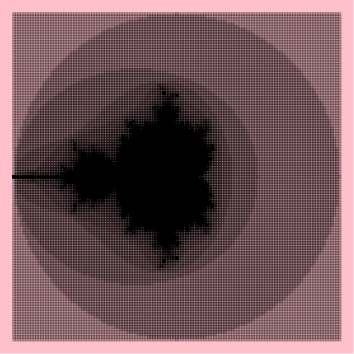

In [12]:
diagram $ (vcat . map hcat $ image) # bgFrame 5 pink

## Charts

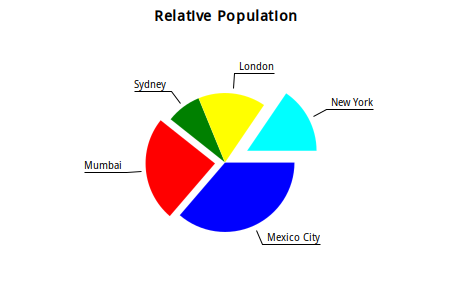

In [13]:
import Graphics.Rendering.Chart 
import Data.Default.Class
import Control.Lens

let values = [
     ("Mexico City"  , 19.2, 0),
     ("Mumbai"       , 12.9, 10), 
     ("Sydney"       , 4.3,  0),
     ("London"       , 8.3,  0), 
     ("New York"     , 8.2,  25)]
     
pitem (s, v, o) = pitem_value .~ v
                $ pitem_label .~ s
                $ pitem_offset .~ o
                $ def  

-- Convert to a renderable in order to display it.
toRenderable 
  $ pie_title .~ "Relative Population"
  $ pie_plot . pie_data .~ map pitem values
  $ def

In [14]:
import Graphics.Rendering.Chart
import Data.Colour
import Data.Colour.Names
import Data.Default.Class
import Control.Lens

In [15]:
chart borders = toRenderable layout
  where
  layout = 
        layout_title .~ "Sample Bars" ++ btitle
      $ layout_title_style . font_size .~ 10
      $ layout_x_axis . laxis_generate .~ autoIndexAxis alabels
      $ layout_y_axis . laxis_override .~ axisGridHide
      $ layout_left_axis_visibility . axis_show_ticks .~ False
      $ layout_plots .~ [ plotBars bars2 ]
      $ def :: Layout PlotIndex Double

  bars2 = plot_bars_titles .~ ["Cash","Equity"]
      $ plot_bars_values .~ addIndexes [[20,45],[45,30],[30,20],[70,25]]
      $ plot_bars_style .~ BarsClustered
      $ plot_bars_spacing .~ BarsFixGap 30 5
      $ plot_bars_item_styles .~ map mkstyle (cycle defaultColorSeq)
      $ def

  alabels = [ "Jun", "Jul", "Aug", "Sep", "Oct" ]

  btitle = if borders then "" else " (no borders)"
  bstyle = if borders then Just (solidLine 1.0 $ opaque black) else Nothing
  mkstyle c = (solidFillStyle c, bstyle)

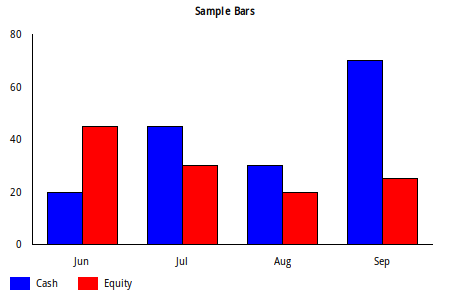

In [16]:
chart True

## `ihaskell.gnuplot`
`IHaskell.Display` instances for the [__gnuplot__ Haskell package](https://hackage.haskell.org/package/gnuplot).

Requires [__gnuplot__](http://www.gnuplot.info/) installed in the environment. Example: `apt-get install gnuplot-nox`.

## Notes from [the source code](                                     https://github.com/gibiansky/IHaskell/blob/master/ihaskell-display/ihaskell-gnuplot/IHaskell/Display/Gnuplot.hs)
There are 3 types of plots to consider in *haskell-gnuplot*: `Plot`, `Frame` and `Multiplot`.
`Plot` types are the actual plots, whereas `Frame` types are plots with additional options
e.g. custom axes tics, graph title etc.. `Multiplot`s are collections of 2D and/or 3D plots.

__Note:__ To stop gnuplot from printing the filepath on top of the canvas, you have to set
the gnuplot option `key` to `"noautotitle"`.
__Code:__

    Graphics.Gnuplot.Frame.cons (Graphics.Gnuplot.Frame.OptionSet.add
                                                    (Graphics.Gnuplot.Frame.Option.key "")
                                                    ["noautotitle"] $ ...)

In [17]:
import IHaskell.Display.Gnuplot
import Graphics.Gnuplot.Plot.TwoDimensional
import Graphics.Gnuplot.Graph.TwoDimensional as Type

Example from https://hackage.haskell.org/package/gnuplot/docs/Graphics-Gnuplot-Plot-TwoDimensional.html#v:function

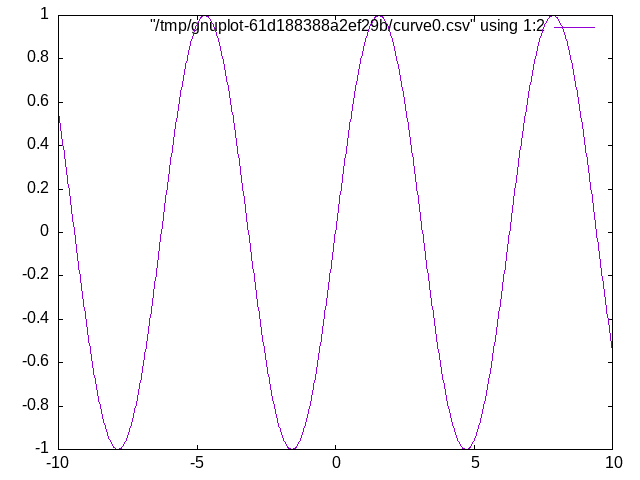

In [18]:
function Type.lines (linearScale 1000 (-10,10)) sin

## `ihaskell.plot`
Example from https://hackage.haskell.org/package/plot-0.2.3.9/docs/Graphics-Rendering-Plot.html

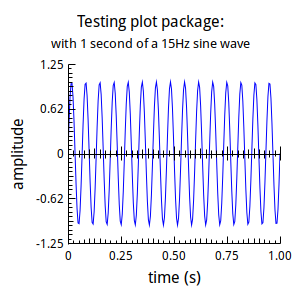

In [19]:
{-# LANGUAGE FlexibleContexts #-}

import qualified Graphics.Rendering.Plot as Plot
import qualified Numeric.LinearAlgebra as LinAlg

-- Create some data

let
  stddev = sqrt . foldl (\acc x -> acc + (x*x))

  ln = 25
  ts = LinAlg.linspace ln (0,1)
  -- rs = LinAlg.randomVector 0 LinAlg.Gaussian ln
  -- ss = sin (15*2*pi*ts)
  -- ds = 0.25*rs + ss
  -- es = LinAlg.konst (0.25*(stddev rs)) ln

  fs :: Double -> Double
  fs = sin . (15*2*pi*)

-- Perform actions in 'Figure a' to create a figure

test_graph :: Plot.Figure ()
test_graph = do
  Plot.withTextDefaults $ Plot.setFontFamily "OpenSymbol"
  Plot.withTitle $ Plot.setText "Testing plot package:"
  Plot.withSubTitle $ do
      Plot.setText "with 1 second of a 15Hz sine wave"
      Plot.setFontSize 10
  Plot.setPlots 1 1
  Plot.withPlot (1,1) $ do
      -- setDataset (ts,[point (ds,es) (Cross,red),line fs blue])
      Plot.setDataset (ts,[Plot.line fs blue])
      Plot.addAxis Plot.XAxis (Plot.Side Plot.Lower) $ Plot.withAxisLabel $ Plot.setText "time (s)"
      Plot.addAxis Plot.YAxis (Plot.Side Plot.Lower) $ Plot.withAxisLabel $ Plot.setText "amplitude"
      Plot.addAxis Plot.XAxis (Plot.Value 0) $ return ()
      Plot.setRangeFromData Plot.XAxis Plot.Lower Plot.Linear
      Plot.setRange Plot.YAxis Plot.Lower Plot.Linear (-1.25) 1.25
                         
test_graph 

## `ihaskell.graphviz`

In [20]:
import qualified Data.GraphViz as G
import qualified Data.GraphViz.Attributes.Complete as G
import qualified Data.GraphViz.Types as G

import qualified Data.Text.Lazy as TL
import qualified Data.Text.Lazy.IO as TL
import System.FilePath.Posix
import System.Directory
import System.IO